In [1]:
import math 
import pandas as pd
import pandas_datareader as web 
import numpy as np 
import matplotlib.pyplot as plt 

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

sample = 50
percentage = 0.75
stock = 'AAPL'
data_source_name = 'yahoo'
start_date = '2010-01-01'
end_date = '2020-11-05'

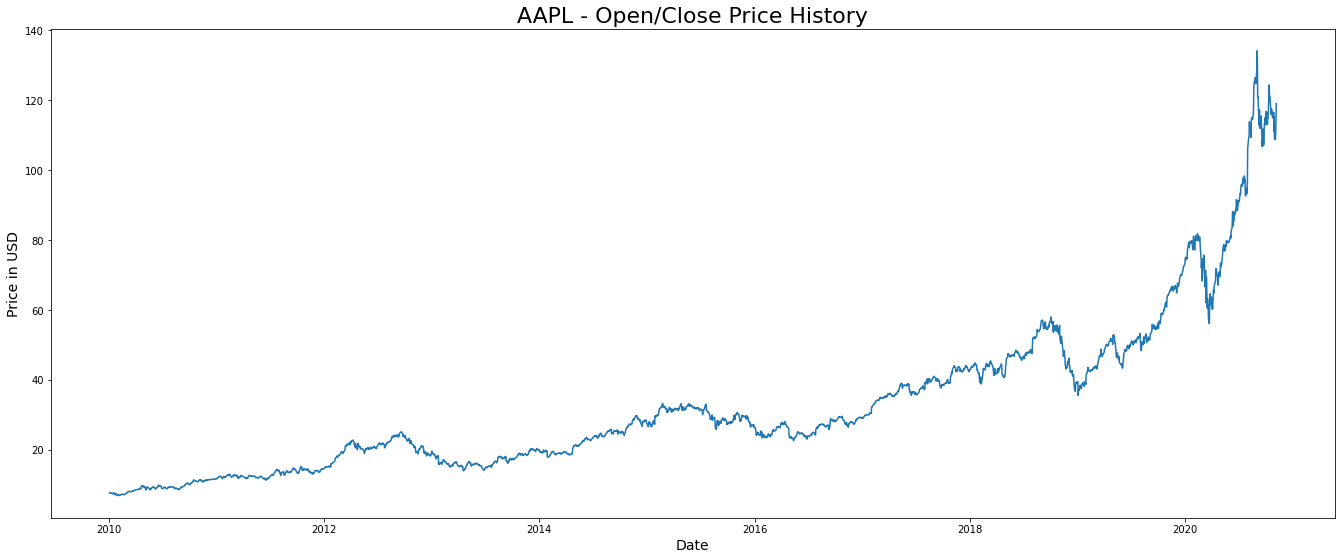

In [24]:
# Create DataFrame and show Close price chart
df = web.DataReader(stock, data_source=data_source_name, start=start_date, end=end_date)
plt.figure(figsize=(23, 9))
plt.title(stock + ' - Open/Close Price History', fontsize=22)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price in USD', fontsize=14)
plt.show()

In [29]:
# Create a sorted DataSet based on Date and Close price
data = df.filter(['Close'])
new_dataset = data.values
data.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-10-23', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29', '2020-10-30', '2020-11-02', '2020-11-03',
               '2020-11-04', '2020-11-05'],
              dtype='datetime64[ns]', name='Date', length=2731, freq=None)

In [4]:
# Prepare train_data and valid_data
train_data_len = math.ceil(len(new_dataset) * percentage)
train_data = new_dataset[0:train_data_len, :]
valid_data = new_dataset[train_data_len:, :]
print('Train data len: ', len(train_data))
print('Valid data len: ', len(valid_data))

Train data len:  2049
Valid data len:  682


In [30]:
# Scale the data
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(new_dataset)
x_train_data, y_train_data = [], []

# Train until the last <sample> values
for i in range(sample, train_data_len):
    x_train_data.append(scaled_data[i-sample:i, 0])     # first len-<sample> values
    y_train_data.append(scaled_data[i, 0])          
print('x_train_data data len: ', len(x_train_data))
print('y_train_data data len: ', len(y_train_data))

x_train_data data len:  1999
y_train_data data len:  1999


In [31]:
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))
x_train_data.shape[0], x_train_data.shape[1]

(1999, 50)

In [7]:
# Build and train the LSTM model (Long Short Term Memory) 
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
lstm_model.fit(x_train_data, y_train_data, batch_size=1, epochs=1)

1999/1999 [==============================] - 20s 10ms/step - loss: 5.0957e-05


In [33]:
# Take a sample of dataset to make stock prediction using LSTM model
test_data = scaled_data[train_data_len-sample:, :]
X_test = []
y_test = new_dataset[train_data_len:, :]
for i in range(sample, len(test_data)):
    X_test.append(test_data[i-sample:i, 0])
X_test = np.array(X_test)
X_test.shape

(682, 50)

In [34]:
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(682, 50, 1)

In [35]:
# Now get the predicted values
predicted_closed_price = lstm_model.predict(X_test)
# Apply inverse transformation
predicted_closed_price = scaler.inverse_transform(predicted_closed_price)

In [36]:
# Get the RMSE (root squared mean error)
rmse = np.sqrt( np.mean(predicted_closed_price - y_test) **2 )
rmse

1.6456753291692203

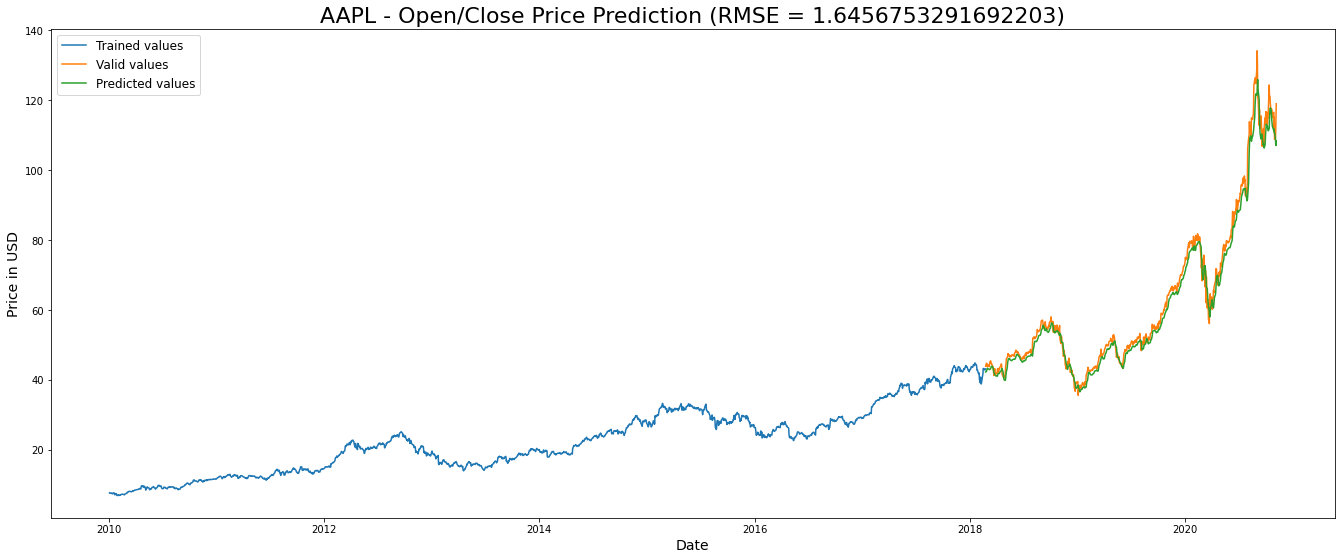

In [37]:
# Plot the data
valid = []
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predicted_closed_price

plt.figure(figsize=(23, 9))
plt.title(stock + ' - Open/Close Price Prediction (RMSE = ' + str(rmse) + ")", fontsize=22)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price in USD', fontsize=14)
plt.legend(['Trained values', 'Valid values', 'Predicted values'], fontsize=12)
plt.show()